In [99]:
from IPython.display import display, clear_output
from pandas.plotting import bootstrap_plot
from datetime import datetime
import yfinance as yf
import pandas as pd
import numpy as np

In [6]:
def get_tickers(file=r"Stock names.txt"):
    with open(file) as f:
        tickers = f.read().split("\n")
    return [ticker for ticker in tickers if "." not in ticker]
    return tickers

In [47]:
def get_basic_info(stock):
    data = stock.info
    change52 = None
    history = stock.history(period="1y", interval="3mo")
    if not history.empty:
        change52 = ((max(history["High"]) - min(history["Low"])) / min(history["Low"])) * 100
    div_yield = data["dividendYield"]  # * 100
    div_ex = pd.to_datetime(data["exDividendDate"], unit='s')  # Ex date
    payout = data["payoutRatio"] # * 100
    trail_div_yield = data["trailingAnnualDividendYield"]  # * 100
    avg_yield_5y = data["fiveYearAvgDividendYield"]
    
    return div_yield, trail_div_yield, div_ex, payout, avg_yield_5y, change52

In [55]:
def get_div_info(stock):
    tmp = stock.dividends
    div_df = pd.DataFrame(index=tmp.index)
    div_df["Dividends"] = tmp
    div_df.index = div_df.index.year
    div_df = div_df.groupby(div_df.index).mean()
    
    div_df["Growth year"] = ((div_df["Dividends"]/div_df["Dividends"].shift(1)) - 1) * 100
    div_df["DGR"] = div_df["Growth year"].expanding().mean()
    div_df["DGR5y"] = div_df["Growth year"].rolling(5).mean()
    div_df["DGR3y"] = div_df["Growth year"].rolling(3).mean()
    div_df["DGR10y"] = div_df["Growth year"].rolling(10).mean()
    div_df['Years grow'] = np.where(div_df['Growth year'] >= 0, div_df['Growth year'].groupby((div_df['Growth year'] < 0).cumsum()).cumcount(), 0)
    
    # div_df["CAGR1y"] = (div_df['Growth year'].iloc[-1]/div_df['Growth year'].iloc[0])**(1/1) - 1
    growth_rate = float(div_df.tail(1)["DGR"])
    growth_year = int(div_df.tail(1)["Years grow"])  # Years of growth
    growth_rate_3 = float(div_df.tail(1)["DGR3y"])
    growth_rate_5 = float(div_df.tail(1)["DGR5y"])
    growth_rate_10 = float(div_df.tail(1)["DGR10y"])
    
    return growth_rate, growth_year, growth_rate_3, growth_rate_5, growth_rate_10

In [56]:
def main():
    tickers = get_tickers(file=r"Champions.txt")
    # tickers = ["CCMP", "O"]
    # tickers = ["ABM"]
    
    tickers = yf.Tickers(tickers)
    df = pd.DataFrame(columns=["div yield", "Trailing annual div yield", "exDiv", "payout ratio", "5 year yield average", "52W change", "DGR", "Years of grow", "DGR3y", 
                          "DGR5y", "DGR10y"])
    
    for ticker in tickers.tickers:
        # print(ticker, end=", ")
        stock = yf.Ticker(ticker)
        fail = False
        while True:
            try:
                div_info = get_div_info(stock)
                basic_info = get_basic_info(stock)
            except TypeError:
                fail = True
                break
            except ConnectionError:
                print("Connection error")
                time.sleep(15)
                continue
            break
        if fail:
            continue
        df.loc[ticker] = basic_info[0], basic_info[1], basic_info[2], basic_info[3], basic_info[4], basic_info[5], div_info[0], div_info[1], div_info[2], div_info[3], div_info[4]
        clear_output(wait=True)
        display(df)

    df["payout ratio"] *= 100
    df["div yield"] *= 100
    df["Trailing annual div yield"] *= 100
    
    return df

In [57]:
df = main()

,div yield,Trailing annual div yield,exDiv,payout ratio,5 year yield average,52W change,DGR,Years of grow,DGR3y,DGR5y,DGR10y
EPD,0.0759,0.000000,2023-01-30,0.7520,7.54,24.999998,6.123165,25,3.274453,2.704221,3.812281
TDS,0.0520,0.051181,2022-12-14,1.7439,3.23,110.572057,5.710178,34,2.942874,3.035886,3.906206
ENB,0.0642,0.084134,2023-02-14,1.2648,6.51,34.032876,10.221437,0,6.180382,9.851278,10.176155
UVV,0.0573,0.056915,2023-04-06,1.0950,5.58,44.991637,4.974402,37,1.078152,4.142561,4.885383
UHT,0.0512,0.049260,2022-12-15,0.3642,4.16,44.656834,2.205189,35,1.449478,1.471225,1.446916
...,...,...,...,...,...,...,...,...,...,...,...
BRO,0.0078,0.007194,2023-02-02,0.1783,0.82,39.648519,10.589478,36,9.751815,8.577949,9.547560
ROP,0.0063,0.005877,2023-01-06,0.2755,0.53,36.670712,18.513229,26,10.010738,10.587577,15.381667
ALB,0.0055,0.005445,2022-12-15,0.1194,1.32,97.751804,11.724059,23,2.400106,4.347713,7.186689
WST,0.0027,0.002554,2023-01-24,0.0873,0.34,105.409491,7.036547,36,5.353512,5.927092,7.048439


In [58]:
df.sort_values("div yield", ascending=False)

,div yield,Trailing annual div yield,exDiv,payout ratio,5 year yield average,52W change,DGR,Years of grow,DGR3y,DGR5y,DGR10y
EPD,7.59,0.000000,2023-01-30,75.200000,7.54,24.999998,6.123165,25,3.274453,2.704221,3.812281
ENB,6.42,8.413402,2023-02-14,126.480010,6.51,34.032876,10.221437,0,6.180382,9.851278,10.176155
UVV,5.73,5.691499,2023-04-06,109.500000,5.58,44.991637,4.974402,37,1.078152,4.142561,4.885383
TDS,5.20,5.118110,2022-12-14,174.390000,3.23,110.572057,5.710178,34,2.942874,3.035886,3.906206
WBA,5.16,5.078229,2023-02-15,NaN,3.73,57.677636,12.187269,37,2.182122,4.367645,6.815050
...,...,...,...,...,...,...,...,...,...,...,...
BMI,0.76,0.719729,2022-11-23,37.610000,0.94,67.147172,10.433715,18,9.929511,11.671992,9.975016
RNR,0.71,0.000000,2022-12-14,NaN,0.89,71.973524,6.977038,26,2.858699,2.946280,3.201395
ROP,0.63,0.587678,2023-01-06,27.550000,0.53,36.670712,18.513229,26,10.010738,10.587577,15.381667
ALB,0.55,0.544546,2022-12-15,11.939999,1.32,97.751804,11.724059,23,2.400106,4.347713,7.186689


In [98]:
# SORT BY CLOSEST EXDATE TO TODAY
today = pd.Timestamp(datetime.now().date())
cop = df.copy()
cop['Difference'] = (df['exDiv'] - today).dt.total_seconds()
cop["Difference"] = np.where(cop["Difference"] < 0, 999999999, cop["Difference"])
# Sort the DataFrame based on the absolute value of the difference
cop.sort_values(by='Difference', key=lambda x: abs(x)).head(30)


,div yield,Trailing annual div yield,exDiv,payout ratio,5 year yield average,52W change,DGR,Years of grow,DGR3y,DGR5y,DGR10y,Difference
TMP,3.09,2.970297,2023-02-06,39.220002,2.63,25.982395,27.355744,15,4.575187,4.888536,4.699771,172800.0
FUL,1.08,1.006135,2023-02-06,22.620001,1.22,42.785639,7.231129,35,5.207633,4.622444,8.524484,172800.0
EBTC,2.59,2.282851,2023-02-07,23.300000,2.17,41.913631,2.417143,16,8.633366,8.730466,6.455843,259200.0
ADM,2.16,2.004617,2023-02-08,20.750000,2.73,41.664788,22.159489,24,4.581010,4.581628,8.827155,345600.0
SJM,2.68,2.682682,2023-02-09,74.860000,2.97,38.085582,19.556213,13,5.139718,5.618014,7.251964,432000.0
WTRG,2.39,2.271687,2023-02-09,61.670000,2.22,36.181819,6.031261,35,7.003581,6.984215,7.553708,432000.0
DCI,1.46,1.424992,2023-02-09,32.729998,1.57,41.324712,13.080979,35,3.536051,5.115058,10.685288,432000.0
PH,1.62,1.398311,2023-02-09,49.060002,1.63,54.214218,9.085900,37,14.253955,13.954352,12.244147,432000.0
GWW,1.15,0.988795,2023-02-10,23.889999,1.61,57.073073,10.703498,37,6.085503,6.031102,8.369437,518400.0
XOM,3.17,3.193882,2023-02-13,26.770002,5.35,60.047839,6.882998,21,1.154760,3.042357,5.063537,777600.0


In [89]:
df.to_csv("Champions-04-02-23.csv")

In [96]:
df = pd.read_csv("Champions-04-02-23.csv", index_col=0, parse_dates=["exDiv"])

In [120]:
df.loc["IBM"]

div yield                                   4.91
Trailing annual div yield               4.831733
exDiv                        2022-11-09 00:00:00
payout ratio                           337.95002
5 year yield average                        4.82
52W change                             34.262511
DGR                                    18.628999
Years of grow                                 28
DGR3y                                   2.352645
DGR5y                                   3.170972
DGR10y                                  7.776065
Name: IBM, dtype: object

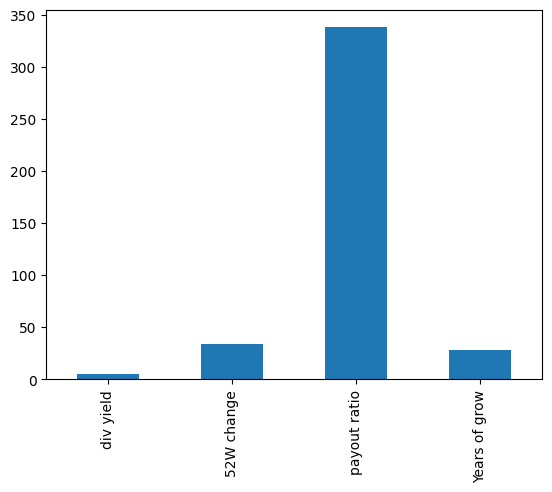

In [126]:
def plot_df(df):
    cop = df.copy()
    # cop.drop(labels=["exDiv"], inplace=True)
    cop = cop[["div yield", "52W change", "payout ratio", "Years of grow"]]
    cop.plot.bar()
    """
    yield 3-4%
    52 change 15%
    payout 1%
    Years 25 = 100
    """
    
    
plot_df(df.loc["IBM"])

In [192]:
def grade_variable(value, high=25, steep=3):
    steep = -3
    return 100 / (1 + np.exp(steep * (value - high)))

grade_variable(2)

100.0

In [269]:
def grade_value(value, a = 0.3, b = 12):
    # return 100 / (1 + np.exp(-steepness * (value - 25)))
    return 100 / (1 + np.exp(-a * (value - b)))

values = range(1, 26)
outputs = []
for val in values:
    outputs.append(grade_value(val))
outputs


[3.557118927263618,
 4.742587317756678,
 6.297335605699651,
 8.317269649392237,
 10.909682119561294,
 14.185106490048781,
 18.242552380635637,
 23.147521650098238,
 28.905049737499606,
 35.43436937742045,
 42.5557483188341,
 50.0,
 57.4442516811659,
 64.56563062257955,
 71.09495026250039,
 76.85247834990176,
 81.75744761936436,
 85.81489350995123,
 89.0903178804387,
 91.68273035060777,
 93.70266439430036,
 95.25741268224333,
 96.44288107273638,
 97.34030064231341,
 98.01596942659225]

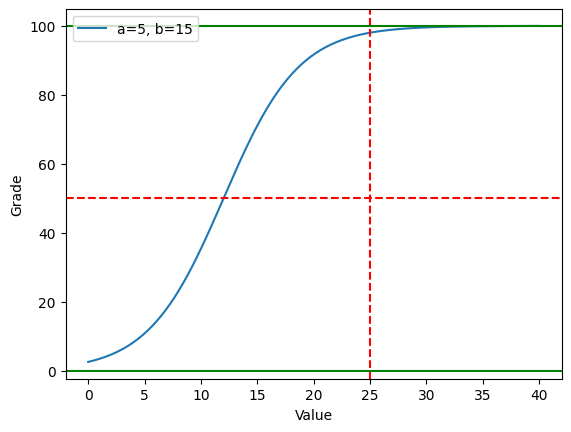

In [275]:
import numpy as np
import matplotlib.pyplot as plt

def grade(value, a, b):
    return 100 / (1 + np.exp(-a * (value - b)))

# Define the range of values to plot
x = np.linspace(0, 40, 300)

# Calculate the grades for different values of a and b
grades_1 = grade(x, a=0.3, b=12)

# Plot the grades
plt.plot(x, grades_1, label="a=5, b=15")
plt.axhline(y=50, color="r", linestyle="--")
plt.axvline(25, color="r", linestyle="--")
plt.axhline(y=100, color="g")
plt.axhline(y=0, color="g")
# Add labels and legend
plt.xlabel("Value")
plt.ylabel("Grade")
plt.legend()

# Show the plot
plt.show()


In [ ]:
24 